In [1]:
import os
import random
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPool2D
from tensorflow.keras.layers import Flatten, Softmax, SpatialDropout2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import time
from keras.utils import Sequence
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

from sklearn.metrics import classification_report

In [2]:
# 데이터 경로 및 설정
base_dir = "kaggle/input/wm811k-wafer-map/wm_images/"

train_dir = os.path.join(base_dir,"train/")

val_dir = os.path.join(base_dir,"val/")
test_dir = os.path.join(base_dir,"test/")
aug_dir = os.path.join(base_dir,"augmented_images/")



In [3]:
class_names = os.listdir(train_dir)
class_names

['Center',
 'Donut',
 'Edge-Loc',
 'Edge-Ring',
 'Loc',
 'Near-full',
 'none',
 'Random',
 'Scratch']

In [4]:
data = []

for folder in [base_dir, aug_dir]:
    
    for subfolder in class_names:
        
        for tp in ['train','val','test']:
            folder_path = os.path.join(folder,tp, subfolder)
            if os.path.exists(folder_path):
                i = 0
                images = os.listdir(folder_path)
                images_count = len(images)
                #print(f"{folder_path} : {images_count}")
                for filename in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, filename)
                    label = subfolder
                    data.append((file_path, label, tp))

df_cls = pd.DataFrame(data, columns=['filepath', 'label','type'])
train_df = pd.DataFrame([], columns=['filepath', 'label','type'])
val_df = pd.DataFrame([], columns=['filepath', 'label','type'])
test_df = pd.DataFrame([], columns=['filepath', 'label','type'])
for cls in class_names:
    train_df = pd.concat([train_df[(train_df['label'] != cls) | (train_df['type'] != 'train')], df_cls[(df_cls['label'] == cls) & (df_cls['type'] == 'train')].iloc[:6500]])
    val_df = pd.concat([val_df[(val_df['label'] != cls) | (val_df['type'] != 'train')], df_cls[(df_cls['label'] == cls) & (df_cls['type'] == 'val')].iloc[:2000]])
    test_df = pd.concat([test_df[(test_df['label'] != cls) | (test_df['type'] != 'train')], df_cls[(df_cls['label'] == cls) & (df_cls['type'] == 'test')].iloc[:1500]])


    
del train_df['type']
del val_df['type']
del test_df['type']

class_namess = train_df['label'].unique().tolist()

In [5]:
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
mcp_save = ModelCheckpoint('.model_compare1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [6]:
image_size = (224, 224)
batch_size = 100
epoch = 20

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
#x_train, y_train = next(train_generator)
#x_train_flatten = x_train.reshape(x_train.shape[0],-1)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
#print(test_generator.classes)

    


Found 58500 validated image filenames belonging to 9 classes.
Found 18000 validated image filenames belonging to 9 classes.
Found 13500 validated image filenames belonging to 9 classes.


In [7]:
'''
from keras.layers import Activation

#SD SD만 포함하고 BN 제거
model = Sequential([
    # Input
    Input(shape=(224, 224, 3)),

    # block 1
    Conv2D(filters=16, kernel_size=(3,3), padding='valid', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),

    # block 2
    Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),

    # block 3
    Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),

    # block 4
    Conv2D(filters=128, kernel_size=(2,2), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=(2,2), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),

    # block 5
    SpatialDropout2D(rate=0.2),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(9, activation='softmax')
])
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#model.summary()


start_time = time.time()
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epoch,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    callbacks=[ early_stop, mcp_save])#,
end_time = time.time()
print(f'{(end_time-start_time)/60}분 소요')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f'training_acc:{acc}')
print(f'validation_acc:{val_acc}')
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model = tf.keras.models.load_model('.model_compare1.hdf5')

loss, accuracy = model.evaluate(test_datagen.flow_from_dataframe(
                    dataframe=test_df,
                    x_col='filepath',
                    y_col='label',
                    target_size=(224, 224),
                    batch_size=batch_size,
                    class_mode='categorical'
                ))
print("Total Loss:", loss)
print("Total Accuracy:", accuracy)


# 전체적인 정확도와 라벨별 정확도 계산
loss, acc = model.evaluate(test_generator)
print("전체 정확도:", acc)

# 라벨별 정확도 계산
predictions = model.predict(test_generator)
pred_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
class_report = classification_report(true_labels, pred_labels, target_names=test_generator.class_indices.keys(),digits=4)
print("라벨별 정확도:")
print(class_report)

scores = model.evaluate_generator(test_generator)


from sklearn.metrics import confusion_matrix

test_generator.batch_size = test_generator.n

test_images, test_labels = test_generator.next()
y_pred_prob = model.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)

# 실제 클래스 레이블 가져오기
y_true = np.argmax(test_labels, axis=1)

# confusion matrix 생성
cm = confusion_matrix(y_true, y_pred)


# 각 클래스(class)의 전체 샘플 수로 나누어서 행(row)을 정규화
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 시각화
sns.heatmap(cm_normalized, annot=True, cmap='Blues')
'''

'\nfrom keras.layers import Activation\n\n#SD SD만 포함하고 BN 제거\nmodel = Sequential([\n    # Input\n    Input(shape=(224, 224, 3)),\n\n    # block 1\n    Conv2D(filters=16, kernel_size=(3,3), padding=\'valid\', kernel_initializer=\'he_normal\'),\n    #BatchNormalization(),\n    Activation(\'relu\'),\n    MaxPool2D(pool_size=(2,2)),\n    Conv2D(filters=16, kernel_size=(3,3), padding=\'same\', kernel_initializer=\'he_normal\'),\n    #BatchNormalization(),\n    Activation(\'relu\'),\n\n    # block 2\n    Conv2D(filters=32, kernel_size=(3,3), padding=\'same\', kernel_initializer=\'he_normal\'),\n    #BatchNormalization(),\n    Activation(\'relu\'),\n    MaxPool2D(pool_size=(2,2)),\n    Conv2D(filters=32, kernel_size=(3,3), padding=\'same\', kernel_initializer=\'he_normal\'),\n    #BatchNormalization(),\n    Activation(\'relu\'),\n\n    # block 3\n    Conv2D(filters=64, kernel_size=(3,3), padding=\'same\', kernel_initializer=\'he_normal\'),\n    #BatchNormalization(),\n    Activation(\'relu\')

In [8]:
'''from tensorflow.keras.layers import Dropout

from keras.layers import Activation
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
mcp_save = ModelCheckpoint('.model_compare2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#D 단순 dropout만 포함하고 SD,BN 제거
model = Sequential([
    # Input
    Input(shape=(224, 224, 3)),

    # block 1
    Conv2D(filters=16, kernel_size=(3,3), padding='valid', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),

    # block 2
    Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),

    # block 3
    Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),

    # block 4
    Conv2D(filters=128, kernel_size=(2,2), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=(2,2), padding='same', kernel_initializer='he_normal'),
    #BatchNormalization(),
    Activation('relu'),

    # block 5
    #SpatialDropout2D(rate=0.2),
    Dropout(0.2), 
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(9, activation='softmax')
])
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#model.summary()


start_time = time.time()
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epoch,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    callbacks=[ early_stop, mcp_save])#,
end_time = time.time()
print(f'{(end_time-start_time)/60}분 소요')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f'training_acc:{acc}')
print(f'validation_acc:{val_acc}')
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model = tf.keras.models.load_model('.model_compare2.hdf5')

loss, accuracy = model.evaluate(test_datagen.flow_from_dataframe(
                    dataframe=test_df,
                    x_col='filepath',
                    y_col='label',
                    target_size=(224, 224),
                    batch_size=batch_size,
                    class_mode='categorical'
                ))
print("Total Loss:", loss)
print("Total Accuracy:", accuracy)


# 전체적인 정확도와 라벨별 정확도 계산
loss, acc = model.evaluate(test_generator)
print("전체 정확도:", acc)

# 라벨별 정확도 계산
predictions = model.predict(test_generator)
pred_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
class_report = classification_report(true_labels, pred_labels, target_names=test_generator.class_indices.keys(),digits=4)
print("라벨별 정확도:")
print(class_report)

scores = model.evaluate_generator(test_generator)


from sklearn.metrics import confusion_matrix

test_generator.batch_size = test_generator.n

test_images, test_labels = test_generator.next()
y_pred_prob = model.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)

# 실제 클래스 레이블 가져오기
y_true = np.argmax(test_labels, axis=1)

# confusion matrix 생성
cm = confusion_matrix(y_true, y_pred)


# 각 클래스(class)의 전체 샘플 수로 나누어서 행(row)을 정규화
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 시각화
sns.heatmap(cm_normalized, annot=True, cmap='Blues')
'''

'from tensorflow.keras.layers import Dropout\n\nfrom keras.layers import Activation\nearly_stop = EarlyStopping(patience=10, monitor=\'val_loss\', restore_best_weights=True)\nmcp_save = ModelCheckpoint(\'.model_compare2.hdf5\', save_best_only=True, monitor=\'val_loss\', mode=\'min\')\n#D 단순 dropout만 포함하고 SD,BN 제거\nmodel = Sequential([\n    # Input\n    Input(shape=(224, 224, 3)),\n\n    # block 1\n    Conv2D(filters=16, kernel_size=(3,3), padding=\'valid\', kernel_initializer=\'he_normal\'),\n    #BatchNormalization(),\n    Activation(\'relu\'),\n    MaxPool2D(pool_size=(2,2)),\n    Conv2D(filters=16, kernel_size=(3,3), padding=\'same\', kernel_initializer=\'he_normal\'),\n    #BatchNormalization(),\n    Activation(\'relu\'),\n\n    # block 2\n    Conv2D(filters=32, kernel_size=(3,3), padding=\'same\', kernel_initializer=\'he_normal\'),\n    #BatchNormalization(),\n    Activation(\'relu\'),\n    MaxPool2D(pool_size=(2,2)),\n    Conv2D(filters=32, kernel_size=(3,3), padding=\'same\', ke

In [9]:
'''
from keras.layers import Activation
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
mcp_save = ModelCheckpoint('.model_compare3.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#BN BN만 포함하고 SD 제거
model = Sequential([
    # Input
    Input(shape=(224, 224, 3)),

    # block 1
    Conv2D(filters=16, kernel_size=(3,3), padding='valid', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),

    # block 2
    Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),

    # block 3
    Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),

    # block 4
    Conv2D(filters=128, kernel_size=(2,2), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=(2,2), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),

    # block 5
    #SpatialDropout2D(rate=0.2),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(9, activation='softmax')
])
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#model.summary()


start_time = time.time()
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epoch,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    callbacks=[ early_stop, mcp_save])#,
end_time = time.time()
print(f'{(end_time-start_time)/60}분 소요')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f'training_acc:{acc}')
print(f'validation_acc:{val_acc}')
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model = tf.keras.models.load_model('.model_compare3.hdf5')

loss, accuracy = model.evaluate(test_datagen.flow_from_dataframe(
                    dataframe=test_df,
                    x_col='filepath',
                    y_col='label',
                    target_size=(224, 224),
                    batch_size=batch_size,
                    class_mode='categorical'
                ))
print("Total Loss:", loss)
print("Total Accuracy:", accuracy)


# 전체적인 정확도와 라벨별 정확도 계산
loss, acc = model.evaluate(test_generator)
print("전체 정확도:", acc)

# 라벨별 정확도 계산
predictions = model.predict(test_generator)
pred_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
class_report = classification_report(true_labels, pred_labels, target_names=test_generator.class_indices.keys(),digits=4)
print("라벨별 정확도:")
print(class_report)

scores = model.evaluate(test_generator)


from sklearn.metrics import confusion_matrix

test_generator.batch_size = test_generator.n

test_images, test_labels = test_generator.next()
y_pred_prob = model.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)

# 실제 클래스 레이블 가져오기
y_true = np.argmax(test_labels, axis=1)

# confusion matrix 생성
cm = confusion_matrix(y_true, y_pred)


# 각 클래스(class)의 전체 샘플 수로 나누어서 행(row)을 정규화
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 시각화
sns.heatmap(cm_normalized, annot=True, cmap='Blues')
'''

'\nfrom keras.layers import Activation\nearly_stop = EarlyStopping(patience=10, monitor=\'val_loss\', restore_best_weights=True)\nmcp_save = ModelCheckpoint(\'.model_compare3.hdf5\', save_best_only=True, monitor=\'val_loss\', mode=\'min\')\n#BN BN만 포함하고 SD 제거\nmodel = Sequential([\n    # Input\n    Input(shape=(224, 224, 3)),\n\n    # block 1\n    Conv2D(filters=16, kernel_size=(3,3), padding=\'valid\', kernel_initializer=\'he_normal\'),\n    BatchNormalization(),\n    Activation(\'relu\'),\n    MaxPool2D(pool_size=(2,2)),\n    Conv2D(filters=16, kernel_size=(3,3), padding=\'same\', kernel_initializer=\'he_normal\'),\n    BatchNormalization(),\n    Activation(\'relu\'),\n\n    # block 2\n    Conv2D(filters=32, kernel_size=(3,3), padding=\'same\', kernel_initializer=\'he_normal\'),\n    BatchNormalization(),\n    Activation(\'relu\'),\n    MaxPool2D(pool_size=(2,2)),\n    Conv2D(filters=32, kernel_size=(3,3), padding=\'same\', kernel_initializer=\'he_normal\'),\n    BatchNormalization()

In [10]:
from tensorflow.keras.applications import VGG16


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

C:\Users\Pc\AppData\Local\Temp\ipykernel_20624\736002135.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(steps_per_epoch=train_generator.samples // batch_size,generator=train_generator,


585/585 [==============================] - 325s 546ms/step - loss: 2.2006 - accuracy: 0.1087 - val_loss: 2.2095 - val_accuracy: 0.1111
Epoch 2/10
585/585 [==============================] - 319s 546ms/step - loss: 2.2005 - accuracy: 0.1112 - val_loss: 2.1973 - val_accuracy: 0.1111
Epoch 3/10
585/585 [==============================] - 318s 544ms/step - loss: 2.1973 - accuracy: 0.1092 - val_loss: 2.1972 - val_accuracy: 0.1111
Epoch 4/10
585/585 [==============================] - 316s 541ms/step - loss: 2.1973 - accuracy: 0.1094 - val_loss: 2.1972 - val_accuracy: 0.1111
Epoch 5/10
585/585 [==============================] - 318s 544ms/step - loss: 2.1973 - accuracy: 0.1075 - val_loss: 2.1972 - val_accuracy: 0.1111
Epoch 6/10
585/585 [==============================] - 317s 541ms/step - loss: 2.1973 - accuracy: 0.1082 - val_loss: 2.1972 - val_accuracy: 0.1111
Epoch 7/10
585/585 [==============================] - 317s 541ms/step - loss: 2.1973 - accuracy: 0.1101 - val_loss: 2.1972 - val_accura

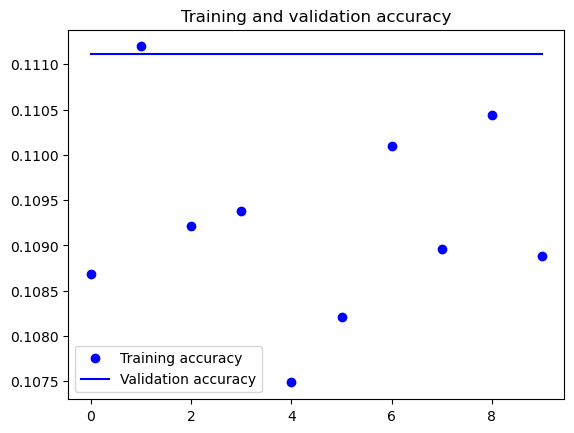

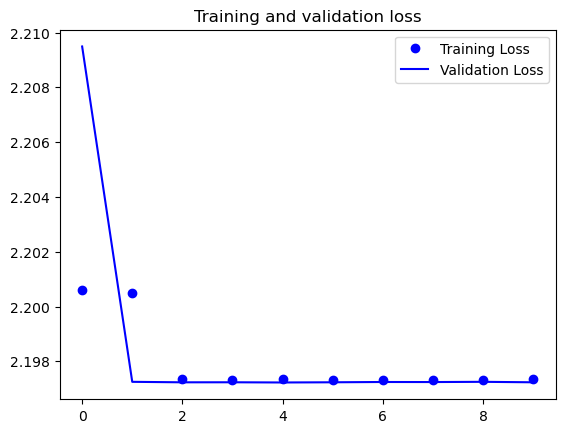

Found 13500 validated image filenames belonging to 9 classes.
135/135 [==============================] - 25s 181ms/step - loss: 2.1972 - accuracy: 0.1111
Total Loss: 2.197227954864502
Total Accuracy: 0.1111111119389534
135/135 [==============================] - 24s 181ms/step - loss: 2.1972 - accuracy: 0.1111
전체 정확도: 0.1111111119389534
135/135 [==============================] - 24s 180ms/step
라벨별 정확도:
              precision    recall  f1-score   support

      Center     0.0000    0.0000    0.0000      1500
       Donut     0.0000    0.0000    0.0000      1500
    Edge-Loc     0.0000    0.0000    0.0000      1500
   Edge-Ring     0.0000    0.0000    0.0000      1500
         Loc     0.0000    0.0000    0.0000      1500
   Near-full     0.1111    1.0000    0.2000      1500
      Random     0.0000    0.0000    0.0000      1500
     Scratch     0.0000    0.0000    0.0000      1500
        none     0.0000    0.0000    0.0000      1500

    accuracy                         0.1111     13500

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


135/135 [==============================] - 25s 181ms/step - loss: 2.1972 - accuracy: 0.1111


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [11]:

from keras.layers import Activation
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
mcp_save = ModelCheckpoint('.model_compare_vgg.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#VGG-16
 
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=9, activation="softmax"))


adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
model.summary()


start_time = time.time()
history = model.fit_generator(steps_per_epoch=train_generator.samples // batch_size,generator=train_generator,
                              validation_data= val_generator, validation_steps=val_generator.samples // batch_size
                              ,epochs=10,callbacks=[early_stop, mcp_save])

end_time = time.time()
print(f'{(end_time-start_time)/60}분 소요')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f'training_acc:{acc}')
print(f'validation_acc:{val_acc}')
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model = tf.keras.models.load_model('.model_compare_vgg.hdf5')

loss, accuracy = model.evaluate(test_datagen.flow_from_dataframe(
                    dataframe=test_df,
                    x_col='filepath',
                    y_col='label',
                    target_size=(224, 224),
                    batch_size=batch_size,
                    class_mode='categorical'
                ))
print("Total Loss:", loss)
print("Total Accuracy:", accuracy)


# 전체적인 정확도와 라벨별 정확도 계산
loss, acc = model.evaluate(test_generator)
print("전체 정확도:", acc)

# 라벨별 정확도 계산
predictions = model.predict(test_generator)
pred_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
class_report = classification_report(true_labels, pred_labels, target_names=test_generator.class_indices.keys(),digits=4)
print("라벨별 정확도:")
print(class_report)

scores = model.evaluate(test_generator)


from sklearn.metrics import confusion_matrix

test_generator.batch_size = test_generator.n

test_images, test_labels = test_generator.next()
y_pred_prob = model.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)

# 실제 클래스 레이블 가져오기
y_true = np.argmax(test_labels, axis=1)

# confusion matrix 생성
cm = confusion_matrix(y_true, y_pred)


# 각 클래스(class)의 전체 샘플 수로 나누어서 행(row)을 정규화
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 시각화
sns.heatmap(cm_normalized, annot=True, cmap='Blues')


In [ ]:

print(tf.__version__)


In [ ]:
'''from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Activation

from tensorflow.keras.models import Sequential
model=Sequential()
# Convolution
model.add(Conv2D(64, (3,3),strides=2,padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))

#Pooling
model.add(MaxPool2D(pool_size=(2,2)))

# Adding second convolutional layer
model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Flattening 
from tensorflow.keras.layers import Flatten
model.add(Flatten())

#Full connection
model.add(Dense(128))
model.add(Activation('relu'))

#Output layer
# Using activation function as linear, because for binary classification we use linear svm.Linear svm means we try to draw a line between the particular classes.
model.add(Dense(1,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear'))

model.compile (
    loss = 'hinge',
    optimizer = 'adam',
    metrics=['accuracy']
)

start_time = time.time()

history=model.fit(x=train_generator, validation_data=val_generator,epochs=5)

end_time = time.time()
print(f'{(end_time-start_time)/60}분 소요')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f'training_acc:{acc}')
print(f'validation_acc:{val_acc}')
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model = tf.keras.models.load_model('.model_compare_vgg.hdf5')

loss, accuracy = model.evaluate(test_datagen.flow_from_dataframe(
                    dataframe=test_df,
                    x_col='filepath',
                    y_col='label',
                    target_size=(224, 224),
                    batch_size=batch_size,
                    class_mode='categorical'
                ))
print("Total Loss:", loss)
print("Total Accuracy:", accuracy)


# 전체적인 정확도와 라벨별 정확도 계산
loss, acc = model.evaluate(test_generator)
print("전체 정확도:", acc)

# 라벨별 정확도 계산
predictions = model.predict(test_generator)
pred_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
class_report = classification_report(true_labels, pred_labels, target_names=test_generator.class_indices.keys(),digits=4)
print("라벨별 정확도:")
print(class_report)

scores = model.evaluate(test_generator)


from sklearn.metrics import confusion_matrix

test_generator.batch_size = test_generator.n

test_images, test_labels = test_generator.next()
y_pred_prob = model.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)

# 실제 클래스 레이블 가져오기
y_true = np.argmax(test_labels, axis=1)

# confusion matrix 생성
cm = confusion_matrix(y_true, y_pred)


# 각 클래스(class)의 전체 샘플 수로 나누어서 행(row)을 정규화
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 시각화
sns.heatmap(cm_normalized, annot=True, cmap='Blues')
'''